- Libraries

In [1]:
import pandas as pd
import numpy as np
from DateTime import DateTime
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy as dc
# from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
# from statsmodels.tsa.stattools import adfuller
# from sklearn.metrics import mean_squared_error
# from statsmodels.tools.eval_measures import rmse
# from sklearn import metrics
import warnings

warnings.filterwarnings("ignore")
from src.functions_torch import TransformLag
from src.feature import TimeConfig


In [2]:
timec= TimeConfig()
df= timec.process_chain(path='../Data/apple.csv',columns=['Close/Last'])


In [3]:
df= df.loc['2019':'2024'].copy()

In [4]:
df


,Value
Date,
2019-01-02,39.4800
2019-01-03,35.5475
2019-01-04,37.0650
2019-01-07,36.9825
2019-01-08,37.6875
...,...
2024-05-22,190.9000
2024-05-23,186.8800
2024-05-24,189.9800


- Plotting the Data

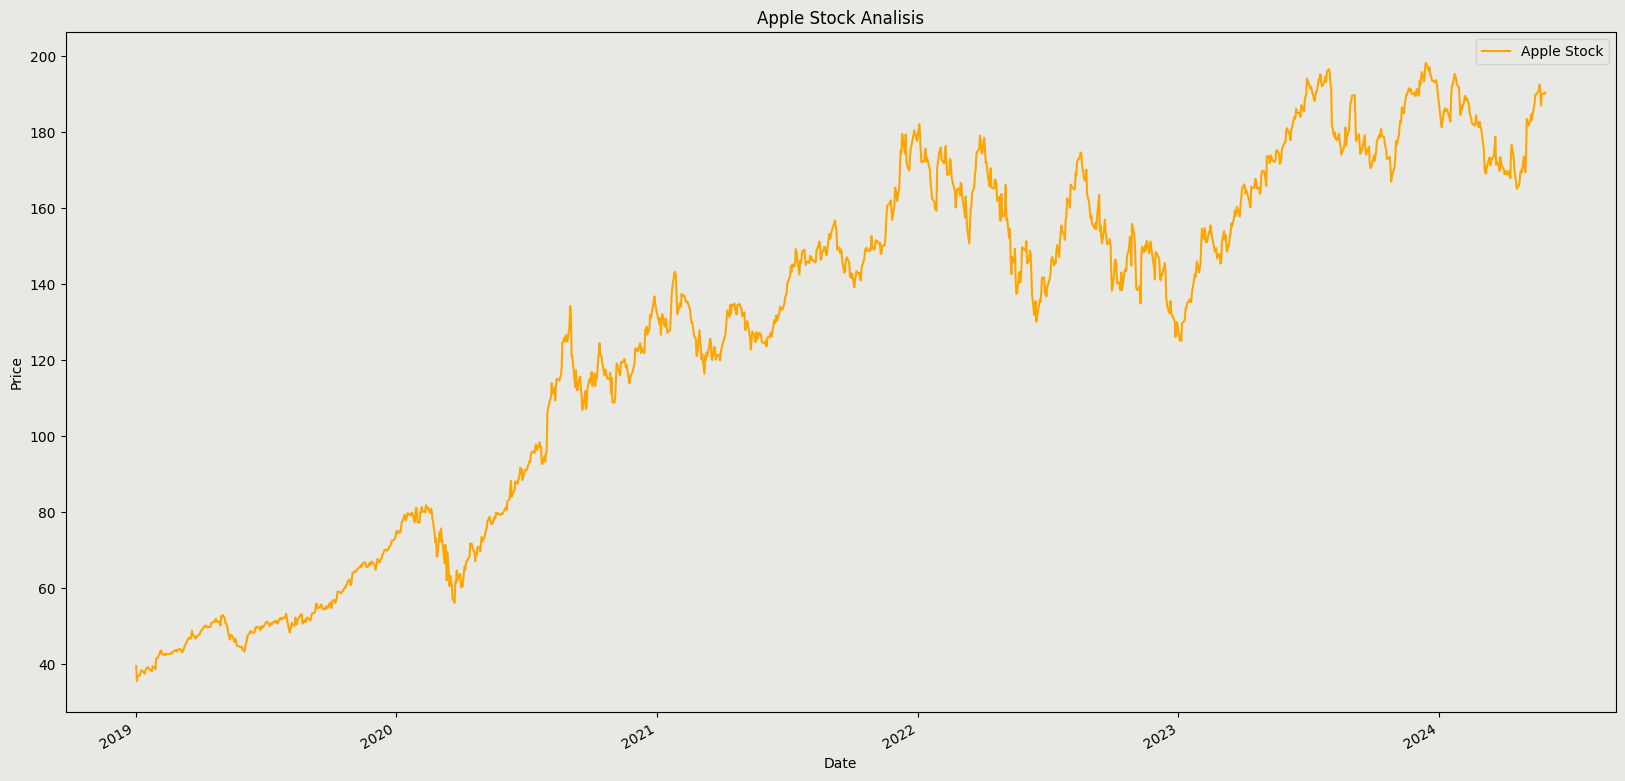

In [5]:
df["Value"].plot(figsize=(20,10),label="Apple Stock",color="orange")
plt.title("Apple Stock Analisis")
plt.xlabel("Date")
plt.ylabel("Price")
plt.gca().set_facecolor("#E8E8E4")
plt.gcf().set_facecolor("#E8E8E4")
plt.legend(facecolor="#E8E8E4")
plt.show()

In [6]:
timef= TransformLag()
data= timef.lag_transform(df,3)

In [7]:
data= data.to_numpy()

- Escalado de valores del array entre -1,1 para alimentar el modelo

In [8]:
scaler= MinMaxScaler(feature_range=(-1,1))
transformed= scaler.fit_transform(data)


- Haciendo Slicing para dividir el dato de entrenamiento y el target

In [9]:
X= transformed[:,1:]
y= transformed[:,0]

In [10]:

X= dc(np.flip(X,axis=1))
split_index= int(len(X) * 0.80)
X_train= X[:split_index]
X_test= X[split_index:]
y_train= y[:split_index]
y_test= y[split_index:]

In [11]:
X_train= X_train.reshape((-1,3,1))
X_test= X_test.reshape((-1,3,1))
y_train= y_train.reshape((-1,1))
y_test= y_test.reshape((-1,1))

In [12]:
X_train= torch.tensor(X_train).float()
X_test= torch.tensor(X_test).float()
y_train= torch.tensor(y_train).float()
y_test= torch.tensor(y_test).float()

In [13]:
class TimeSeries(Dataset):
    def __init__(self,X,y):
        self.X= X
        self.y= y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self,i):
        return self.X[i],self.y[i]

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    
seed=42
set_seed(seed)
batch_size = 18
train_dataset= TimeSeries(X_train,y_train)
test_dataset= TimeSeries(X_test,y_test)

train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

In [14]:
for _,batch in enumerate(train_loader):
    x_batch,y_batch= batch[0].to(device),batch[1].to(device)
    print(x_batch.shape,y_batch.shape)
    break

class LSTM(nn.Module):
    def __init__(self,input_size,hidden_size,num_stacked_layers,dropout_rate=0.05):
        super().__init__()
        self.hidden_size= hidden_size
        self.num_stacked_layers= num_stacked_layers
        
        self.lstm= nn.LSTM(input_size,hidden_size,num_stacked_layers,
                           batch_first=True,dropout=dropout_rate)
        self.fc= nn.Linear(hidden_size,1)
        
    def forward(self,x):
        batch_size= x.size(0)
        h0= torch.zeros(self.num_stacked_layers,batch_size,self.hidden_size).to(device)
        c0= torch.zeros(self.num_stacked_layers,batch_size,self.hidden_size).to(device)
        
        out,_ = self.lstm(x,(h0,c0))
        out= self.fc(out[:,-1,:])
        return out
    
model= LSTM(1,4,1)
model.to(device)

torch.Size([18, 3, 1]) torch.Size([18, 1])


LSTM(
  (lstm): LSTM(1, 4, batch_first=True, dropout=0.05)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [15]:
learning_rate = 0.001
num_epochs = 20
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [16]:
def train_one_epoch():
    model.train(True)
    running_loss = 0.0

    for _, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    avg_train_loss = running_loss / len(train_loader)
    return avg_train_loss
  
    
def validate_one_epoch():
    model.eval()
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    return avg_loss_across_batches

 

Epoch 1/20, Train Loss: 0.27368850413371215, Validation Loss: 0.5860360183499076
Epoch 2/20, Train Loss: 0.21774763961068608, Validation Loss: 0.3877150362188166
Epoch 3/20, Train Loss: 0.10470032137395306, Validation Loss: 0.12866446816108443
Epoch 4/20, Train Loss: 0.012572716548509727, Validation Loss: 0.03619897433302619
Epoch 5/20, Train Loss: 0.003271899379218336, Validation Loss: 0.02932707237249071
Epoch 6/20, Train Loss: 0.003106816845088774, Validation Loss: 0.027791057776829057
Epoch 7/20, Train Loss: 0.0029797424080739306, Validation Loss: 0.02686881362883882
Epoch 8/20, Train Loss: 0.0028471619774460455, Validation Loss: 0.02501803388903764
Epoch 9/20, Train Loss: 0.002723479173834097, Validation Loss: 0.023049463824877006
Epoch 10/20, Train Loss: 0.0026254899395015937, Validation Loss: 0.021436126775700937
Epoch 11/20, Train Loss: 0.0025205775269899855, Validation Loss: 0.021029565546830945
Epoch 12/20, Train Loss: 0.0023895338421094825, Validation Loss: 0.020294885701415

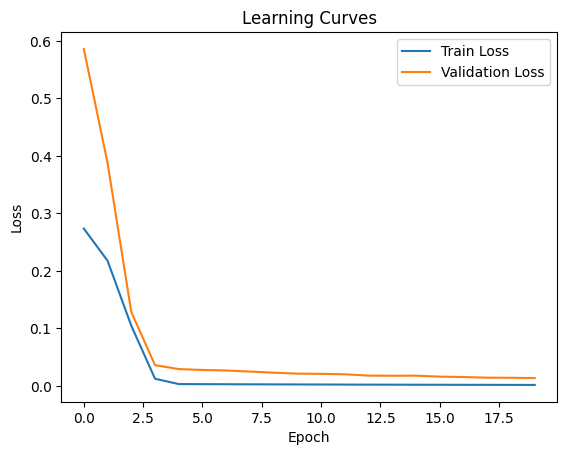

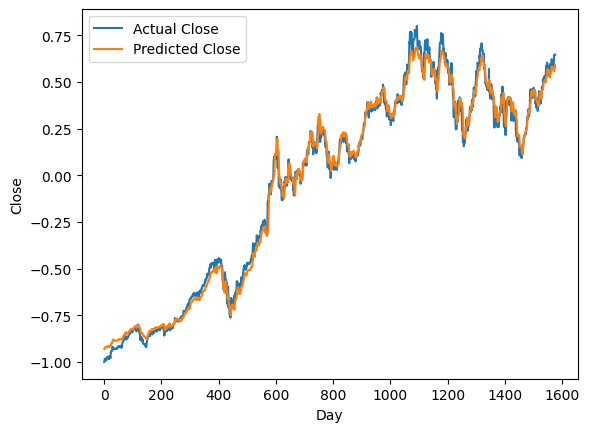

In [17]:
train_losses=[]
val_losses=[]

for epoch in range(num_epochs):
    train_loss= train_one_epoch()
    val_loss= validate_one_epoch()
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}')

    with torch.no_grad():
        model.eval()
        predicted = model(X_train.to(device)).to('cpu').numpy()

# Plotting the learning curves
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curves')
plt.show()
plt.plot(y_train[-200:], label='Actual Close')
plt.plot(predicted[:200], label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

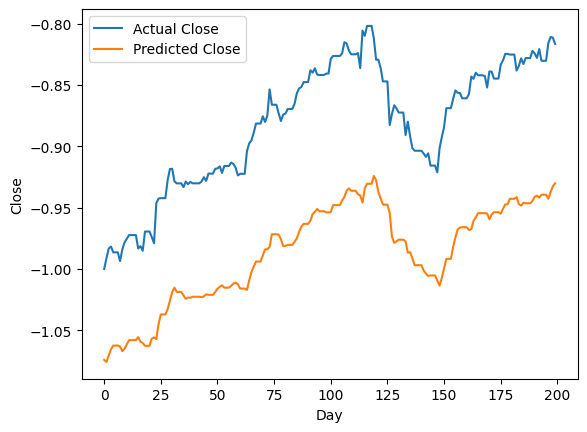

In [28]:
plt.plot(y_train[:200], label='Actual Close')
plt.plot(predicted[:200], label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [18]:
train_predictions = predicted.flatten()
dummies = np.zeros((X_train.shape[0], 3+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)
train_predictions = dc(dummies[:, 0])


In [19]:
dummies = np.zeros((X_train.shape[0], 3+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])


In [20]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], 3+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])


In [21]:
dummies = np.zeros((X_test.shape[0], 3+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])


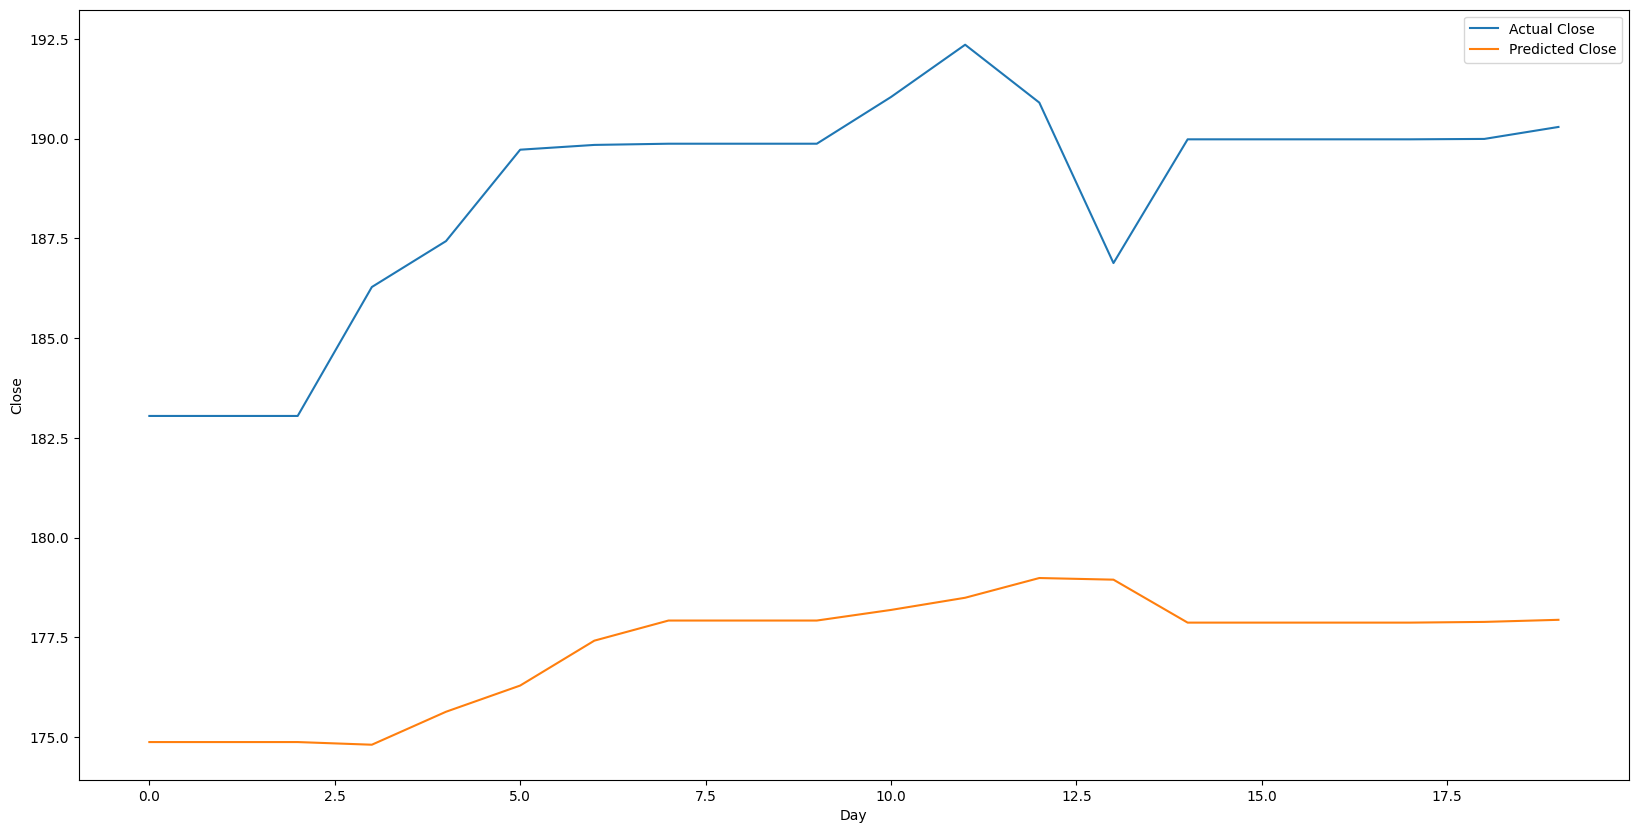

In [22]:
plt.figure(figsize=(20,10))
plt.plot(new_y_test[-20:], label='Actual Close')
plt.plot(test_predictions[-20:], label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [23]:
import matplotlib.pyplot as plt

# Redefine the DataLoader for retraining if necessary
new_train_loader = test_loader

def train_one_epoch():
    model.train()
    running_loss = 0.0

    for batch in train_loader:
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        # Forward pass
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_train_loss = running_loss / len(new_train_loader.dataset)
    return avg_train_loss

# Training loop
train_losses = []

for epoch in range(num_epochs):
    train_loss = train_one_epoch()
    train_losses.append(train_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}')

    # Prediction for plotting
    with torch.no_grad():
        model.eval()
        predicted = model(X_train.to(device)).cpu().numpy()

Epoch 1/20, Train Loss: 0.0003896566185577853
Epoch 2/20, Train Loss: 0.0003790187259112499
Epoch 3/20, Train Loss: 0.0003728491465707645
Epoch 4/20, Train Loss: 0.00036431862232523505
Epoch 5/20, Train Loss: 0.0003555727922263068
Epoch 6/20, Train Loss: 0.0003491750428438905
Epoch 7/20, Train Loss: 0.00033831473813406406
Epoch 8/20, Train Loss: 0.00033566442115568005
Epoch 9/20, Train Loss: 0.0003330046791160186
Epoch 10/20, Train Loss: 0.0003207555942788134
Epoch 11/20, Train Loss: 0.0003167747100046954
Epoch 12/20, Train Loss: 0.00030923030634060844
Epoch 13/20, Train Loss: 0.00030178658080377103
Epoch 14/20, Train Loss: 0.00029945841589753473
Epoch 15/20, Train Loss: 0.00029594480012174753
Epoch 16/20, Train Loss: 0.0002914624081701182
Epoch 17/20, Train Loss: 0.0002866000963669261
Epoch 18/20, Train Loss: 0.0002821624536967841
Epoch 19/20, Train Loss: 0.0002794754801484695
Epoch 20/20, Train Loss: 0.00027731990605370536


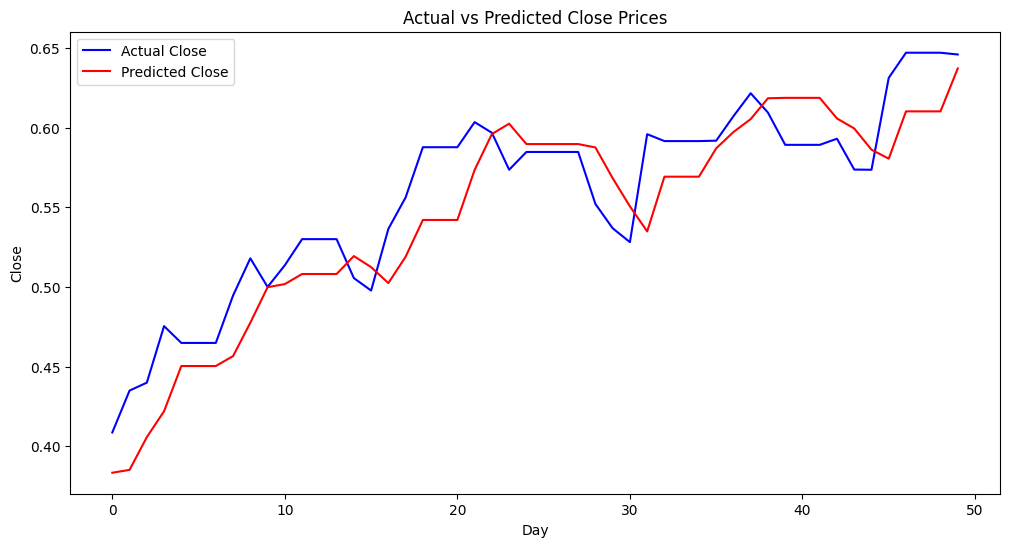

In [27]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_train[-50:], label='Actual Close', color='blue')
plt.plot(predicted[-50:], label='Predicted Close', color='red')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.title('Actual vs Predicted Close Prices')
plt.show()

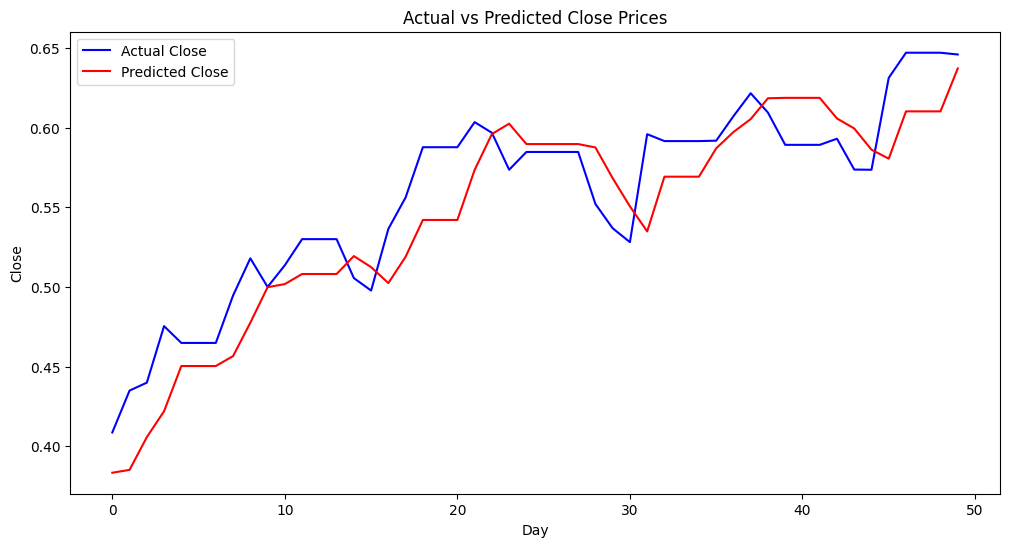

In [ ]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_train[-50:], label='Actual Close', color='blue')
plt.plot(predicted[-50:], label='Predicted Close', color='red')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.title('Actual vs Predicted Close Prices')
plt.show()

In [26]:
"""new_train_loader= test_loader

def train_one_epoch():
    model.train(True)
    running_loss = 0.0

    for _, batch in enumerate(new_train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    avg_train_loss = running_loss / len(new_train_loader)
    return avg_train_loss

train_losses=[]

for epoch in range(num_epochs):
    train_loss= train_one_epoch()
    
    train_losses.append(train_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}')

    with torch.no_grad():
        model.eval()
        predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train[-50:], label='Actual Close')
plt.plot(predicted[-50:], label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()"""

"new_train_loader= test_loader\n\ndef train_one_epoch():\n    model.train(True)\n    running_loss = 0.0\n\n    for _, batch in enumerate(new_train_loader):\n        x_batch, y_batch = batch[0].to(device), batch[1].to(device)\n\n        output = model(x_batch)\n        loss = loss_function(output, y_batch)\n        running_loss += loss.item()\n\n        optimizer.zero_grad()\n        loss.backward()\n        optimizer.step()\n    avg_train_loss = running_loss / len(new_train_loader)\n    return avg_train_loss\n\ntrain_losses=[]\n\nfor epoch in range(num_epochs):\n    train_loss= train_one_epoch()\n    \n    train_losses.append(train_loss)\n    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}')\n\n    with torch.no_grad():\n        model.eval()\n        predicted = model(X_train.to(device)).to('cpu').numpy()\n\nplt.plot(y_train[-50:], label='Actual Close')\nplt.plot(predicted[-50:], label='Predicted Close')\nplt.xlabel('Day')\nplt.ylabel('Close')\nplt.legend()\nplt.show()"